In [1]:
import matplotlib.pyplot as plt
import pydicom

In [2]:
import os

In [3]:
dir_dicom = os.path.join(os.getcwd(), 'rsna-pneumonia-detection-challenge')
os.listdir(dir_dicom)

['stage_2_test_images',
 '.DS_Store',
 'stage_2_detailed_class_info.csv',
 'stage_2_sample_submission.csv',
 'stage_2_train_images',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_train_labels.csv']

In [4]:
import pandas

In [5]:
df = pandas.read_csv(os.path.join(dir_dicom, 'stage_2_train_labels.csv'))
df.head(10)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [6]:
import matplotlib.patches as patches



Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name...: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id.......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)



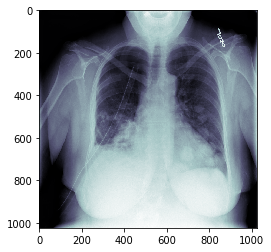


Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name...: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd, 
Patient id.......: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 111474 bytes
Pixel spacing....: [0.19431099999999998, 0.19431099999999998]
Slice location...: (missing)



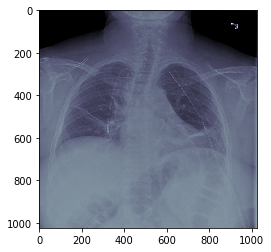


Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name...: 00322d4d-1c29-4943-afc9-b6754be640eb, 
Patient id.......: 00322d4d-1c29-4943-afc9-b6754be640eb
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 124270 bytes
Pixel spacing....: [0.168, 0.168]
Slice location...: (missing)



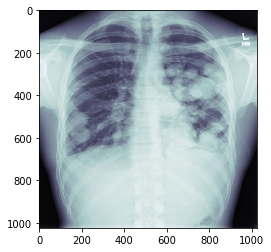


Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name...: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, 
Patient id.......: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 155284 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)



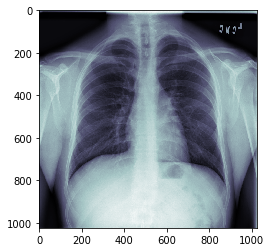


Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name...: 00436515-870c-4b36-a041-de91049b9ab4, 
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 119382 bytes
Pixel spacing....: [0.139, 0.139]
Slice location...: (missing)



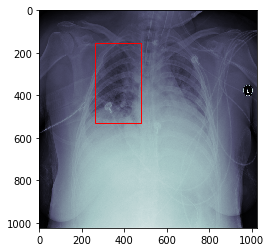


Storage type.....: 1.2.840.10008.5.1.4.1.1.7
Patient's name...: 00436515-870c-4b36-a041-de91049b9ab4, 
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 119382 bytes
Pixel spacing....: [0.139, 0.139]
Slice location...: (missing)



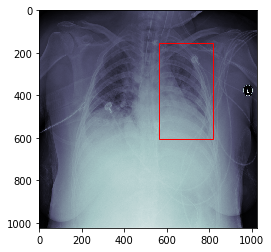

In [8]:
dicoms_training = os.path.join(dir_dicom, 'stage_2_train_images')

count = 0
for index, row in df.iterrows():
    patientId = row.patientId
    x = row.x
    y = row.y
    width = row.width
    height = row.height
    Target = row.Target

    _dicom = pydicom.dcmread(os.path.join(dicoms_training, patientId + '.dcm'))
    print()
    print("Storage type.....:", _dicom.SOPClassUID)
    pat_name = _dicom.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name...:", display_name)
    print("Patient id.......:", _dicom.PatientID)
    print("Modality.........:", _dicom.Modality)
    print("Study Date.......:", _dicom.StudyDate)
    if 'PixelData' in _dicom:
        rows = int(_dicom.Rows)
        cols = int(_dicom.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(_dicom.PixelData)))
    if 'PixelSpacing' in _dicom:
        print("Pixel spacing....:", _dicom.PixelSpacing)

    # use .get() if not sure the item exists, and want a default value if missing
    print("Slice location...:", _dicom.get('SliceLocation', "(missing)"))
    print()
    


    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(_dicom.pixel_array, cmap=plt.cm.bone)#cmap stands for color map

    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()
    
    count += 1
    
    if count > 5:
        break


